# TASK 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


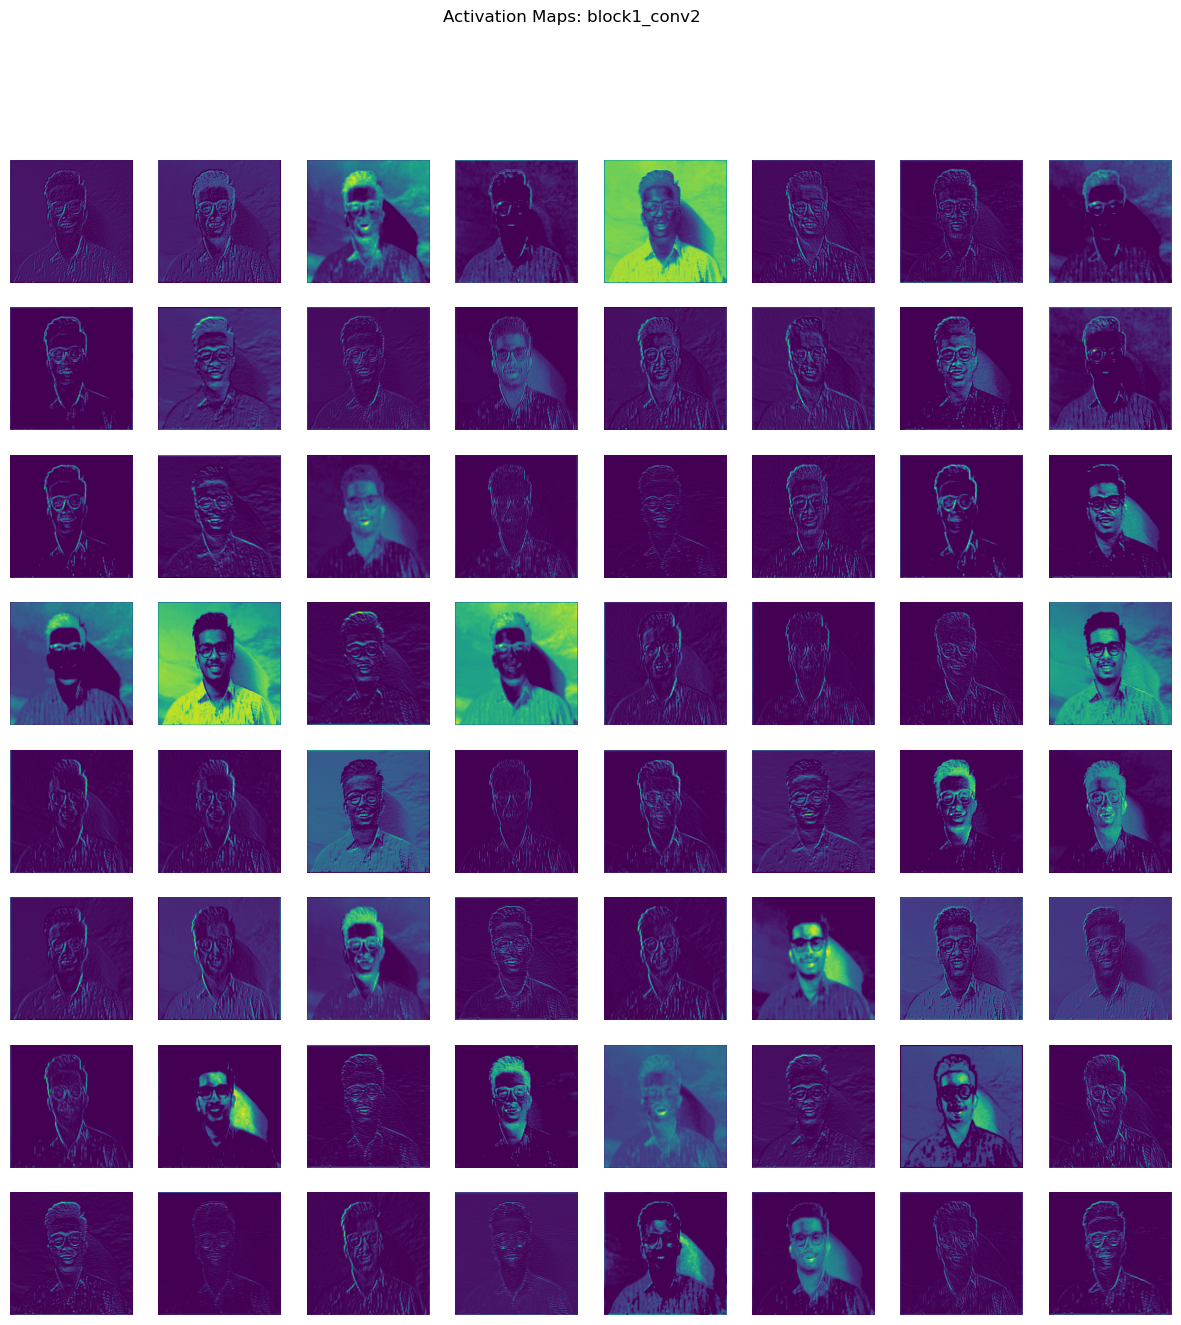

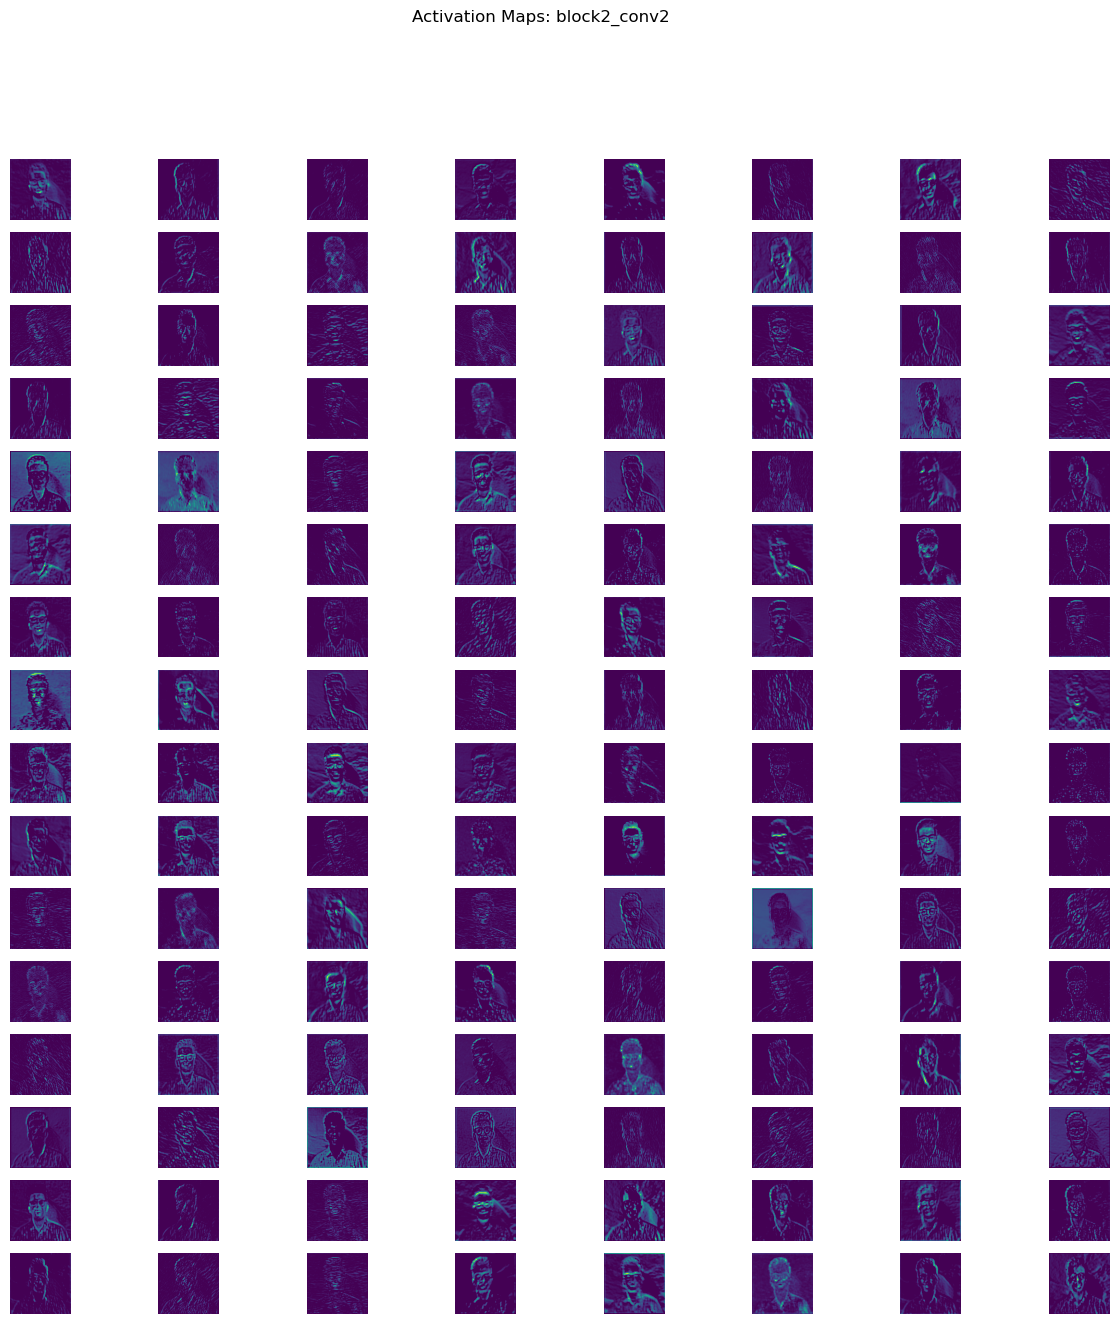

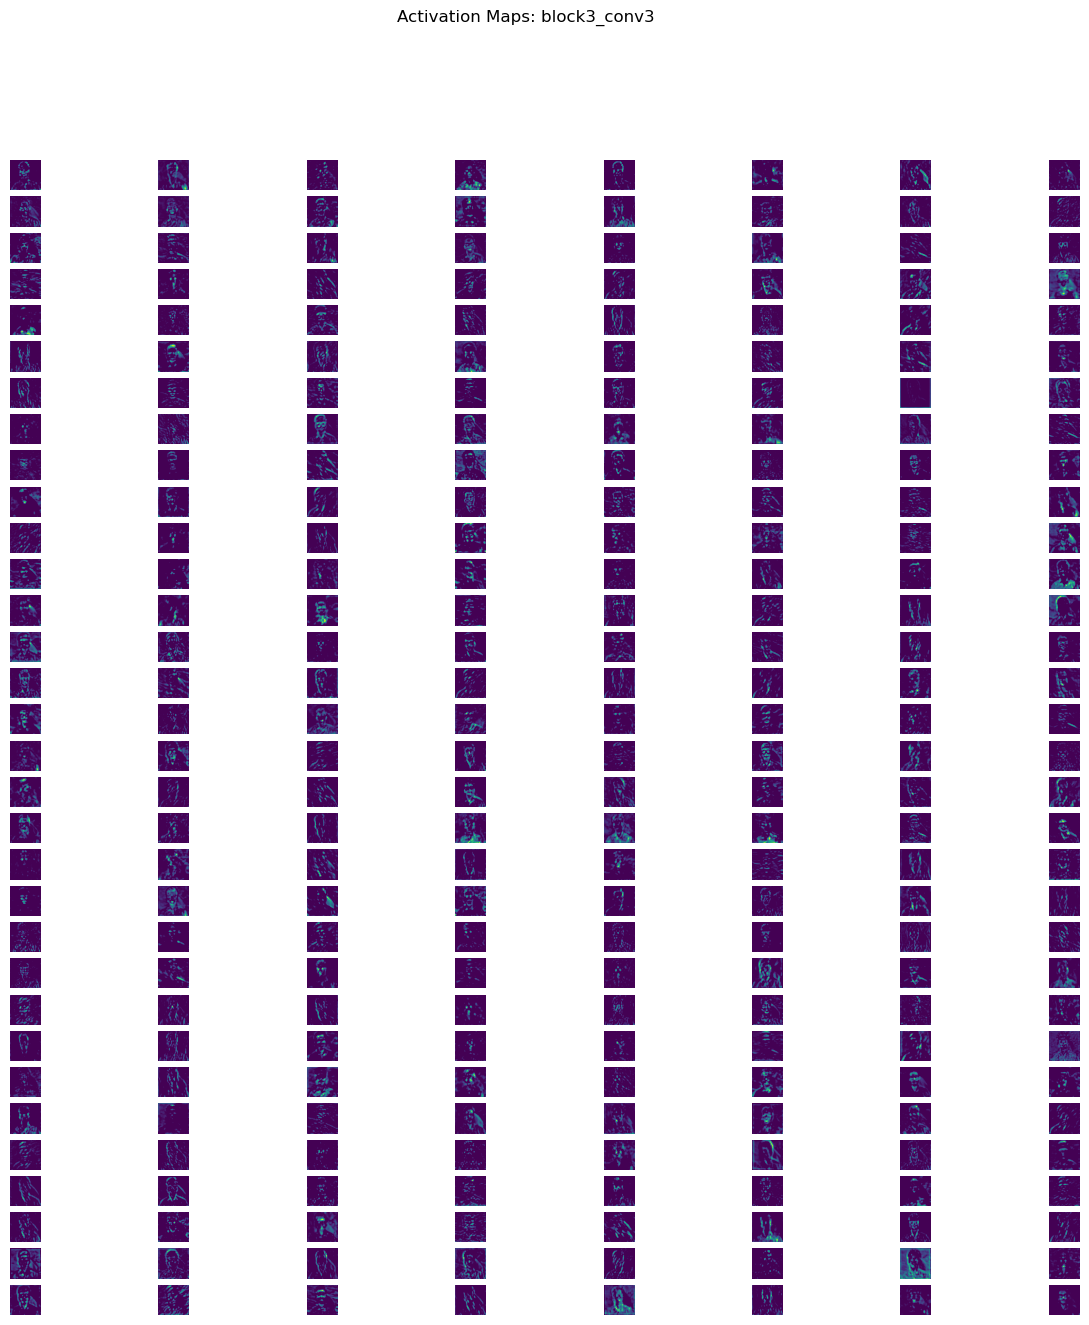

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

def get_activation_maps(model, image, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    activations = activation_model.predict(image)
    return activations

def plot_activation_maps(activations, layer_names, cols=8):
    for layer_name, activation in zip(layer_names, activations):
        num_filters = activation.shape[-1]
        rows = num_filters // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
        fig.suptitle(f'Activation Maps: {layer_name}')
        for i in range(rows * cols):
            row, col = divmod(i, cols)
            if i < num_filters:
                axes[row, col].imshow(activation[0, :, :, i], cmap='viridis')
                axes[row, col].axis('off')
        plt.show()

# Function to generate Grad-CAM visualization
def generate_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_max(predictions)
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap[0]

# Function to overlay heatmap on image
def overlay_heatmap(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, 0.6, img, 0.4, 0)
    return superimposed_img
# Load a pre-trained model (VGG16 for example)
model = VGG16(weights='imagenet', include_top=False)

# Select layers to visualize
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3']

# Load and preprocess the image
image_path = 'mihir_photo.jpg'  # Update with actual path
image = load_and_preprocess_image(image_path)

# Get activations
activations = get_activation_maps(model, image, layer_names)

# Plot activations
plot_activation_maps(activations, layer_names)


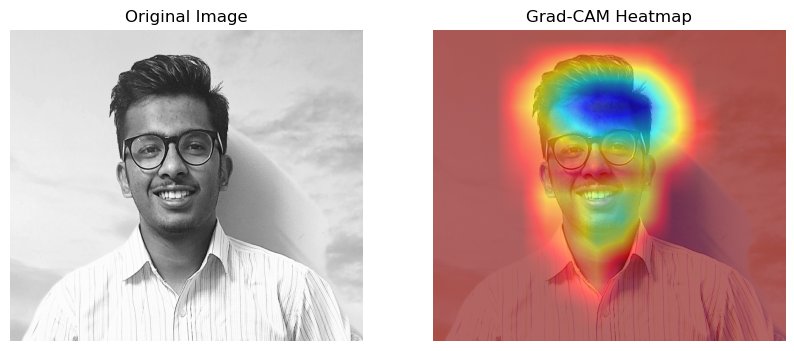

In [14]:
image_path = 'mihir_photo.jpg'  # Replace with FER2013 sample image path
if not os.path.exists(image_path):
    print(f"Image not found: {image_path}. Please provide a valid image.")
else:
    img_array = load_and_preprocess_image(image_path)
    heatmap = generate_gradcam(model, img_array)
    superimposed_img = overlay_heatmap(image_path, heatmap)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()